Exploratory Data Analysis - Credit Card Fraud Detection
=======================================================
Objective: Understand the data characteristics and fraud patterns.

In [1]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')
import os
os.chdir('..')

from src.data.loader import DataLoader

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Imports sucessful")

Imports sucessful


In [12]:
# Load Data
loader = DataLoader()
df = loader.load_data()

info = loader.get_basic_info(df)

print("=" * 50)
print("📊 DATASET OVERVIEW")
print("=" * 50)
for key, value in info.items():
    print(f"{key:20s}: {value}")

2025-09-25 23:46:39,564 - INFO - Loading data from data\raw\creditcard.csv
2025-09-25 23:46:40,476 - INFO - Data validation passed!
2025-09-25 23:46:40,477 - INFO - Loaded 284,807 transactions
2025-09-25 23:46:40,478 - INFO - Fraud rate: 0.17%
2025-09-25 23:46:40,479 - INFO - Memory usage: 67.4 MB


📊 DATASET OVERVIEW
n_transactions      : 284807
n_features          : 30
fraud_rate          : 0.17%
n_frauds            : 492
n_normal            : 284315
imbalance_ratio     : 577.9:1
memory_mb           : 67.4
time_span_hours     : 48.0


In [13]:
# Data Quality Check
print("=" * 50)
print("🔍 DATA QUALITY ASSESSMENT")
print("=" * 50)

# Check for missing values
missing = df.isnull().sum().sum()
print(f"Missing values: {missing}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# Check data types
print(f"All numeric: {df.select_dtypes(include=[np.number]).shape[1] == df.shape[1]}")

# Check value ranges for target
print(f"\nTarget Variable:")
print(df['Class'].value_counts())
print(f"\nFraud Rate: {df['Class'].mean():.4f} ({df['Class'].mean()*100:.2f}%)")

🔍 DATA QUALITY ASSESSMENT
Missing values: 0
Duplicate rows: 1081
All numeric: True

Target Variable:
Class
0    284315
1       492
Name: count, dtype: int64

Fraud Rate: 0.0017 (0.17%)


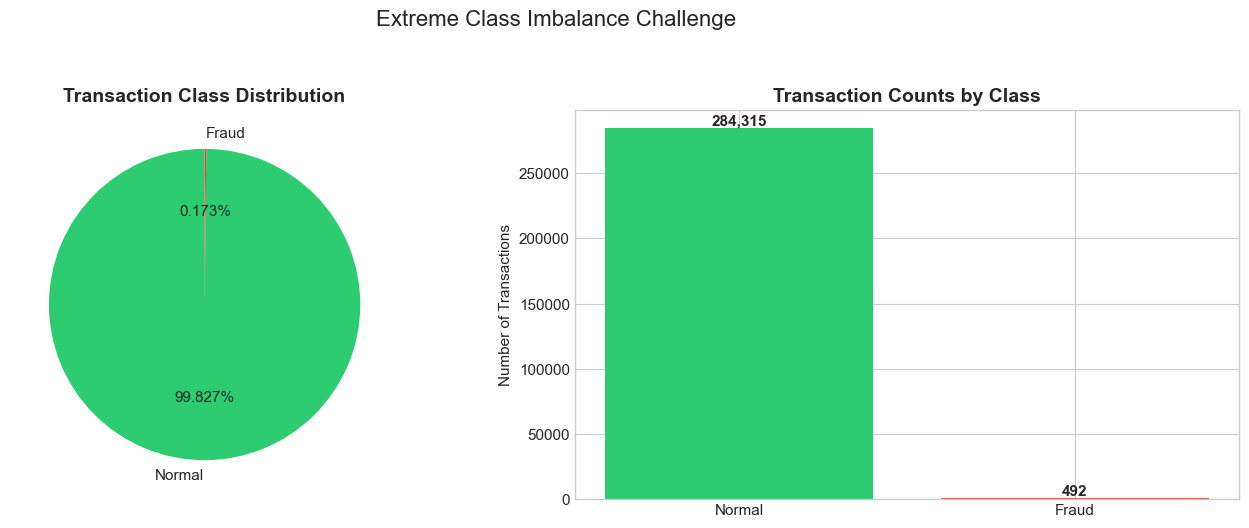

In [4]:
# Class Distribution Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
ax1 = axes[0]
class_counts = df['Class'].value_counts()
colors = ['#2ecc71', '#e74c3c']
ax1.pie(class_counts.values, labels=['Normal', 'Fraud'], 
        autopct='%1.3f%%', colors=colors, startangle=90)
ax1.set_title('Transaction Class Distribution', fontsize=14, fontweight='bold')

# Bar chart with counts
ax2 = axes[1]
bars = ax2.bar(['Normal', 'Fraud'], class_counts.values, color=colors)
ax2.set_ylabel('Number of Transactions')
ax2.set_title('Transaction Counts by Class', fontsize=14, fontweight='bold')

# Value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Extreme Class Imbalance Challenge', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

<small>Insight: With only 0.17% fraud rate, we have a severe imbalance problem \
Ratio: 577.9 normal transactions for every 1 fraud</small>

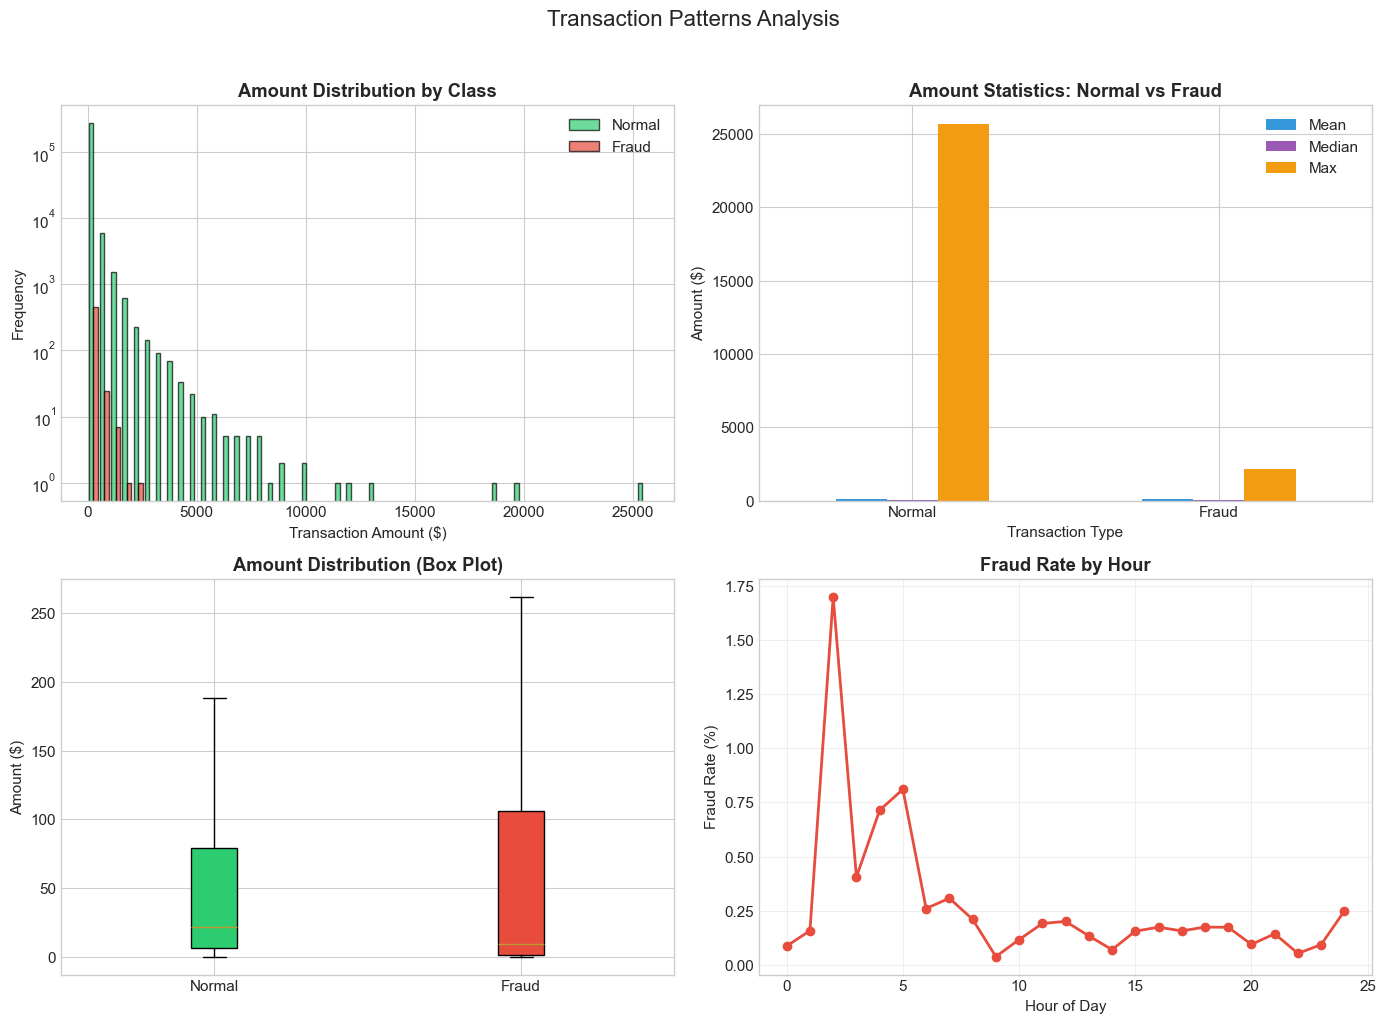

Key Amount Statistics:
Normal transactions: Mean=$88.29, Median=$22.00
Fraud transactions:  Mean=$122.21, Median=$9.25

Insight: Fraudulent transactions tend to have lower amounts!
Median fraud ($9.25) < Median normal ($22.00)


In [18]:
# Transaction Amount Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Amount distribution by class
ax1 = axes[0, 0]
normal_amounts = df[df['Class'] == 0]['Amount']
fraud_amounts = df[df['Class'] == 1]['Amount']

ax1.hist([normal_amounts, fraud_amounts], bins=50, 
         label=['Normal', 'Fraud'], color=['#2ecc71', '#e74c3c'],
         alpha=0.7, edgecolor='black')
ax1.set_xlabel('Transaction Amount ($)')
ax1.set_ylabel('Frequency')
ax1.set_title('Amount Distribution by Class', fontweight='bold')
ax1.set_yscale('log')  # Log scale to see both classes
ax1.legend()

# Statistical comparison
ax2 = axes[0, 1]
amount_stats = pd.DataFrame({
    'Normal': normal_amounts.describe(),
    'Fraud': fraud_amounts.describe()
}).T[['mean', '50%', 'max']]  # 50% is median

amount_stats.plot(kind='bar', ax=ax2, color=['#3498db', '#9b59b6', '#f39c12'])
ax2.set_title('Amount Statistics: Normal vs Fraud', fontweight='bold')
ax2.set_xlabel('Transaction Type')
ax2.set_ylabel('Amount ($)')
ax2.set_xticklabels(['Normal', 'Fraud'], rotation=0)
ax2.legend(['Mean', 'Median', 'Max'])

# Box plot comparison (better for outliers)
ax3 = axes[1, 0]
plot_data = pd.DataFrame({
    'Normal': normal_amounts.sample(1000),  # Sample for visibility
    'Fraud': fraud_amounts
})
box = ax3.boxplot([normal_amounts.sample(1000), fraud_amounts], 
                   labels=['Normal', 'Fraud'],
                   patch_artist=True, showfliers=False)
box['boxes'][0].set_facecolor('#2ecc71')
box['boxes'][1].set_facecolor('#e74c3c')
ax3.set_ylabel('Amount ($)')
ax3.set_title('Amount Distribution (Box Plot)', fontweight='bold')

# Time patterns
ax4 = axes[1, 1]
# Time is seconds from start of dataset
df['Hour'] = (df['Time'] / 3600) % 24
hourly_fraud_rate = df.groupby(df['Hour'].round())['Class'].mean() * 100

ax4.plot(hourly_fraud_rate.index, hourly_fraud_rate.values, 
         marker='o', color='#e74c3c', linewidth=2)
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Fraud Rate (%)')
ax4.set_title('Fraud Rate by Hour', fontweight='bold')
ax4.grid(True, alpha=0.3)
df = df.drop('Hour', axis=1)

plt.suptitle('Transaction Patterns Analysis', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Key statistics
print("Key Amount Statistics:")
print(f"Normal transactions: Mean=${normal_amounts.mean():.2f}, Median=${normal_amounts.median():.2f}")
print(f"Fraud transactions:  Mean=${fraud_amounts.mean():.2f}, Median=${fraud_amounts.median():.2f}")
print(f"\nInsight: Fraudulent transactions tend to have lower amounts!")
print(f"Median fraud (${fraud_amounts.median():.2f}) < Median normal (${normal_amounts.median():.2f})")

In [19]:
# Accuracy Fails
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Simulate a "dumb" model that predicts everything as normal
y_true = df['Class'].values
y_pred_all_normal = np.zeros_like(y_true)  # Predict everything as 0 (normal)

# Calculate metrics
accuracy = (y_pred_all_normal == y_true).mean()
fraud_caught = ((y_pred_all_normal == 1) & (y_true == 1)).sum()
total_frauds = (y_true).sum()

print("=" * 50)
print(f"If we predict EVERYTHING as normal (no fraud):")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Frauds caught: {fraud_caught} out of {total_frauds} (0%)")
print(f"Business impact: ALL fraud goes undetected! 💸")
print("ACCURACY IS MISLEADING")
print("=" * 50)

If we predict EVERYTHING as normal (no fraud):
Accuracy: 0.9983 (99.83%)
Frauds caught: 0 out of 492 (0%)
Business impact: ALL fraud goes undetected! 💸
ACCURACY IS MISLEADING


Better Metrics for Imbalanced Data:
<small>
<li>Precision: Of predicted frauds, how many are real? Reduced false alarms.</li>
<li>Recall: Of actual frauds, how many did we catch? Reduces fraud losses.</li>
<li>F1 Score: Balance between precision and recall.</li>
<li>AUC-PR: Area under Precision-Recall curve.</li>
</small>
<br>
For Fraud Detection, we want:
<small>
<li>High recall and Reasonable precision</li>
</small>

In [21]:
# Finding Important Features
from sklearn.ensemble import RandomForestClassifier

feature_cols = [col for col in df.columns if col not in ['Class', 'Time']]
X = df[feature_cols]
y = df['Class']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Number of features we'll analyze: {len(feature_cols)} features")

X shape: (284807, 29)
y shape: (284807,)
Number of features we'll analyze: 29 features
